# Land Type Classification using Sentinel-2 Satellite Images
### **MobileNet Edition** (Bayesian Optimization)
***

#### Some tests for GPU `tensorflow`

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.python.platform.build_info import build_info

print("CUDA:", build_info["cuda_version"])
print("cuDNN:", build_info["cudnn_version"])

CUDA: 64_112
cuDNN: 64_8


#### Limited VRAM usage as CUDA allocate the whole entirety of VRAM

In [3]:
# from tensorflow.config.experimental import list_physical_devices, VirtualDeviceConfiguration, set_virtual_device_configuration #type:ignore
# vram_GB = 2 
# gpus = list_physical_devices('GPU')
# if gpus:
#     try:
#         set_virtual_device_configuration( gpus[0], [VirtualDeviceConfiguration(memory_limit= vram_GB * 1024)] )
#         print(f"[/] Limited GPU memory to {vram_GB} GB.")
#     except RuntimeError as e:
#         print(e)

### Had to re-define `CategoricalFocalLoss` as it was missing in this old version of tensorflow
 - should have the same functionanlity

In [4]:
import tensorflow as tf
from tensorflow.keras.losses import Loss #type:ignore
from tensorflow.keras import backend as K #type:ignore

class CategoricalFocalLoss(Loss):
    """
    Categorical focal loss for one-hot labels.
    Usage:
        loss = CategoricalFocalLoss(gamma=2.0, alpha=0.25)
        model.compile(..., loss=loss, ...)
    """
    def __init__(self, gamma=2.0, alpha=0.25, from_logits=False, reduction=tf.keras.losses.Reduction.AUTO, name="categorical_focal_loss"):
        super().__init__(reduction=reduction, name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha) if alpha is not None else None
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        """
        y_true: one-hot (batch, classes)
        y_pred: probabilities (softmax) or logits if from_logits=True
        """
        # If logits provided, convert to probabilities
        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred, axis=-1)

        # Clip to avoid log(0) and NaNs
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1.0 - eps)

        # Compute cross-entropy per class
        cross_entropy = -y_true * K.log(y_pred)  # shape (batch, classes)

        # get p_t: the model probability for the true class per sample (elementwise y_true * y_pred)
        p_t = y_true * y_pred  # (batch, classes)

        # focal weighting: (1 - p_t)^gamma
        focal_factor = K.pow(1.0 - p_t, self.gamma)

        if self.alpha is not None:
            alpha_factor = y_true * self.alpha + (1.0 - y_true) * (1.0 - self.alpha)
            # For multiclass one-hot alpha factor reduces to alpha for true class; keep simple:
            alpha_factor = y_true * self.alpha  # only apply alpha to true class entries
        else:
            alpha_factor = 1.0

        # elementwise focal loss
        loss = alpha_factor * focal_factor * cross_entropy  # (batch, classes)

        # sum over classes then mean over batch
        loss = K.sum(loss, axis=-1)
        return K.mean(loss)

    def get_config(self):
        return {"gamma": self.gamma, "alpha": self.alpha, "from_logits": self.from_logits}


***
# Normal Code

In [5]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv

from tensorflow.keras.regularizers import l2 #type:ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD #type:ignore
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.applications import MobileNetV2  #type:ignore
from sklearn.utils.class_weight import compute_class_weight
#from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #type:ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type:ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout #type:ignore
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, LeakyReLU, AveragePooling2D #type:ignore
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix

In [6]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [7]:
from pathlib import Path
import os
import shutil
import random

#### Split data into folders

In [8]:
project_root = Path(os.getcwd()).parent.parent

dataset_root = project_root / "Dataset"
original_folder = dataset_root / "EuroSAT_RGB"
base_folder = dataset_root / "EuroSAT_RGB_split"
results_file = project_root / "Model_Fine_Tuning" / "Bayesian_Optimization" / "MobileNet_bayesian_optimization_results.csv"


checkpoints_dir = project_root / "Model_Fine_Tuning" / "Bayesian_Optimization" / "Checkpoints"


print("Project Root:       ",project_root)
print("Dataset Root:       ",dataset_root)
print("Original Root:      ",original_folder)
print("Base Folder:        ",base_folder)
print("Checkpoints Folder: ",checkpoints_dir)
print("Results file:       ",results_file)

Project Root:        d:\Coding\Jupyter\DEPI\DEPI-Final-Project
Dataset Root:        d:\Coding\Jupyter\DEPI\DEPI-Final-Project\Dataset
Original Root:       d:\Coding\Jupyter\DEPI\DEPI-Final-Project\Dataset\EuroSAT_RGB
Base Folder:         d:\Coding\Jupyter\DEPI\DEPI-Final-Project\Dataset\EuroSAT_RGB_split
Checkpoints Folder:  d:\Coding\Jupyter\DEPI\DEPI-Final-Project\Model_Fine_Tuning\Bayesian_Optimization\Checkpoints
Results file:        d:\Coding\Jupyter\DEPI\DEPI-Final-Project\Model_Fine_Tuning\Bayesian_Optimization\MobileNet_bayesian_optimization_results.csv


In [9]:
def split_data():
    train_ratio = 0.7
    val_ratio = 0.15
    random_state = 42
    random.seed(random_state)

    for split in ["train", "validate", "test"]:
        os.makedirs(os.path.join(base_folder, split), exist_ok=True)
    
    for class_name in os.listdir(original_folder):
        class_path = os.path.join(original_folder, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".png", ".tif"))]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        splits = {
            "train": images[:n_train],
            "validate": images[n_train:n_train + n_val],
            "test": images[n_train + n_val:]
        }

        for split_name, split_images in splits.items():
            split_dir = os.path.join(base_folder, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img_name in split_images:
                src = os.path.join(class_path, img_name)
                dst = os.path.join(split_dir, img_name)
                shutil.copy(src, dst)

        print(f"{class_name}: {n_total} images split into train/val/test")

In [10]:
#split_data()


#### split_data() Output:
 - AnnualCrop: 3000 images split into train/val/test
 - Forest: 3000 images split into train/val/test
 - HerbaceousVegetation: 3000 images split into train/val/test
 - Highway: 2500 images split into train/val/test
 - Industrial: 2500 images split into train/val/test
 - Pasture: 2000 images split into train/val/test
 - PermanentCrop: 2500 images split into train/val/test
 - Residential: 3000 images split into train/val/test 
 - River: 2500 images split into train/val/test 
 - SeaLake: 3000 images split into train/val/test


In [11]:
train_dir = base_folder / "train"
val_dir = base_folder / "validate"
test_dir = base_folder / "test"

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

image_size = (96,96)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

Found 18900 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.


In [13]:
class_labels = train_generator.classes
class_weight_dict = dict(
    enumerate(
        compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
    )
)
class_weight_dict

{0: 0.9,
 1: 0.9,
 2: 0.9,
 3: 1.08,
 4: 1.08,
 5: 1.35,
 6: 1.08,
 7: 0.9,
 8: 1.08,
 9: 0.9}

***
#### Defining Space for Bayesian Optimization

In [14]:
space = [
    Categorical([128, 256, 512], name='dense_units'),
    Real(0.3, 0.6, name='dropout'),
    Categorical(['adam', 'rmsprop', 'sgd'], name='optimizer'),
    Real(1e-5, 5e-3, name='lr', prior='log-uniform'),
    Integer(30, 100, name='unfreeze_layers'),
    Categorical([0.35, 0.5, 0.75, 1.0], name='alpha')
]

***
### **Objective Function for Bayesian Optimization**
 - Defining **Compile** and **Model structure** (Actuall run is in pre-last cell)
 - This function defines the **objective** used by the Bayesian optimizer (`gp_minimize`) to evaluate different CNN hyperparameter combinations.  
It builds, trains, and validates a Convolutional Neural Network (CNN)


In [15]:
@use_named_args(space)
def objective(**params):
    K.clear_session()
    params['dropout'] = round(params['dropout'], 2)
    print(f"\nRunning with params: {params}")

    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(*image_size, 3),
        alpha=params['alpha'],
        pooling='avg'
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        Dense(params['dense_units'], activation='relu'),
        BatchNormalization(),
        Dropout(params['dropout']),
        Dense(train_generator.num_classes, activation='softmax')
    ])

    if params['optimizer'] == 'adam':
        opt = Adam(learning_rate=params['lr'])
    elif params['optimizer'] == 'rmsprop':
        opt = RMSprop(learning_rate=params['lr'])
    else:
        opt = SGD(learning_rate=params['lr'], momentum=0.9)

    model.compile(optimizer=opt, loss=CategoricalFocalLoss(gamma=2.0, alpha=0.25), metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
    ]

    # Phase 1: Train top
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        callbacks=callbacks,
        verbose=0
    )

    # Phase 2: Fine-tune
    base_model.trainable = True
    for layer in base_model.layers[:-params['unfreeze_layers']]:
        layer.trainable = False

    model.compile(optimizer=opt, loss=CategoricalFocalLoss(gamma=2.0, alpha=0.25), metrics=['accuracy'])
    history_ft = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        callbacks=callbacks,
        verbose=0
    )

    preds = model.predict(val_generator, verbose=0)
    y_true = val_generator.classes
    y_pred = np.argmax(preds, axis=1)

    acc = np.mean(y_true == y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    weighted_score = acc * precision * recall * f1

    trial_num = 1
    if os.path.exists(results_file):
        with open(results_file, 'r') as f:
            trial_num = sum(1 for _ in f)

    with open(results_file, 'a', newline='') as f:
        writer = csv.writer(f)
        if trial_num == 1:
            writer.writerow(['trial', 'dense_units', 'dropout', 'optimizer', 'lr', 'unfreeze_layers', 'alpha',
                             'accuracy', 'precision', 'recall', 'f1_score', 'weighted_score'])
        writer.writerow([trial_num, params['dense_units'], params['dropout'], params['optimizer'],
                         params['lr'], params['unfreeze_layers'], params['alpha'],
                         round(acc,6), round(precision,6), round(recall,6), round(f1,6), round(weighted_score,6)]) #type:ignore
    
    print(f"Trial {trial_num}: acc={acc:.4f}, f1={f1:.4f}, weighted={weighted_score:.6f}")
    return -weighted_score


#### print used VRAM

In [16]:
gpus = tf.config.list_physical_devices('GPU')
details = tf.config.experimental.get_memory_info(gpus[0].name[17:])
print(f"GPU: {gpus[0].name}")
print(f"  Used VRAM: {details['current'] / 1024**2:.2f} MB")
print(f"  Peak VRAM: {details['peak'] / 1024**2:.2f} MB")

GPU: /physical_device:GPU:0
  Used VRAM: 0.00 MB
  Peak VRAM: 0.00 MB


***
#### **Load old results**

In [17]:
import pandas as pd

df = pd.read_csv(results_file)
print(f"Loaded {len(df)} past runs from {results_file.name}")
X_old = df[['dense_units', 'dropout', 'optimizer', 'lr', 'unfreeze_layers', 'alpha']].values.tolist()
y_old = [-v for v in df['weighted_score'].values.tolist()]
if len(df) == 0:
    X_old, y_old = None, None;

Loaded 15 past runs from MobileNet_bayesian_optimization_results.csv


***
### **Start Bayesian Optimization**

In [18]:
search_result = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=30,
    x0=X_old,
    y0=y_old,
    random_state=42,
    verbose=True
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0000
Function value obtained: -0.5055
Current minimum: -0.8366
Iteration No: 2 started. Evaluating function at random point.

Running with params: {'dense_units': 512, 'dropout': 0.36, 'optimizer': 'sgd', 'lr': 0.000408207212033996, 'unfreeze_layers': 61, 'alpha': 0.35}
Trial 16: acc=0.8237, f1=0.8204, weighted=0.467919
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1638.8133
Function value obtained: -0.4679
Current minimum: -0.8366
Iteration No: 3 started. Evaluating function at random point.

Running with params: {'dense_units': 256, 'dropout': 0.4, 'optimizer': 'adam', 'lr': 0.0005711214409132686, 'unfreeze_layers': 34, 'alpha': 0.75}
Trial 17: acc=0.9116, f1=0.9119, weighted=0.695327
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1030.3217
Function value obtained: -0.6953
Current minimum: -0.8366
Iteration No: 

In [19]:
print("\nBest Parameters Found:")
print(search_result.x) #type:ignore
print("Best Score:", -search_result.fun) #type:ignore


Best Parameters Found:
[128, 0.49, 'rmsprop', 0.0045051646540252, 63, 1.0]
Best Score: 0.836564


***
#### Read `MobileNet_random_search_results.csv` file

In [20]:
df = pd.read_csv(results_file)
df_sorted = df.sort_values(by="weighted_score", ascending=False)
df_sorted

,trial,dense_units,dropout,optimizer,lr,unfreeze_layers,alpha,accuracy,precision,recall,f1_score,weighted_score
4,5,128,0.49,rmsprop,0.004505,63,1.00,0.956049,0.957277,0.956049,0.956095,0.836564
19,20,128,0.49,rmsprop,0.004505,63,1.00,0.956049,0.956520,0.956049,0.956023,0.835840
34,35,128,0.60,rmsprop,0.005000,73,0.75,0.954815,0.955128,0.954815,0.954835,0.831435
41,42,512,0.30,rmsprop,0.005000,76,0.75,0.954321,0.954904,0.954321,0.954421,0.830020
38,39,128,0.60,rmsprop,0.005000,100,0.75,0.953333,0.956119,0.953333,0.953684,0.828716
36,37,128,0.60,adam,0.005000,73,0.75,0.953333,0.953414,0.953333,0.953065,0.825836
9,10,512,0.40,rmsprop,0.000255,97,1.00,0.952346,0.953433,0.952346,0.952561,0.823706
43,44,128,0.60,rmsprop,0.005000,71,0.75,0.951605,0.952351,0.951605,0.951700,0.820749
35,36,256,0.30,rmsprop,0.005000,73,0.75,0.951111,0.951977,0.951111,0.951193,0.819139
21,22,128,0.37,adam,0.000698,73,1.00,0.950617,0.952022,0.950617,0.950661,0.817870


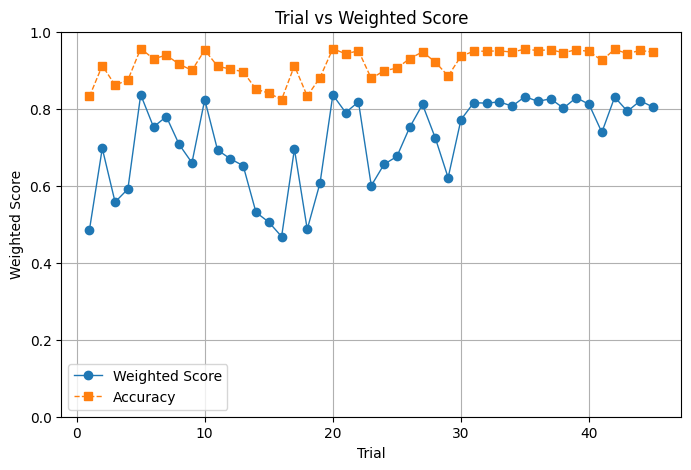

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(df["trial"], df["weighted_score"], marker='o', linestyle='-', linewidth=1, label='Weighted Score')
plt.plot(df["trial"], df["accuracy"], marker='s', linestyle='--', linewidth=1, label='Accuracy')
plt.legend()
plt.xlabel("Trial")
plt.ylabel("Weighted Score")
plt.ylim(0, 1)
plt.title("Trial vs Weighted Score")
plt.grid(True)